## Imports / Data Preparation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tarfile
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
# To safely store your training progress, use Google Drive:
from google.colab import drive

drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/training_progress.'
os.makedirs(save_dir, exist_ok=True)
checkpoint_path = os.path.join(save_dir, 'cp-{epoch:04d}.ckpt')

save_dir_re = '/content/drive/My Drive/training_progress'
os.makedirs(save_dir_re, exist_ok=True)
checkpoint_path_re = os.path.join(save_dir_re, 'cp-{epoch:04d}.ckpt')

save_dir_buf = '/content/drive/My Drive/training_progress'
os.makedirs(save_dir_buf, exist_ok=True)
checkpoint_path_buf = os.path.join(save_dir_buf, 'cp-{epoch:04d}.ckpt')


Mounted at /content/drive


In [3]:
tf.device('/GPU:0')

Download CIFAR-10 dataset from the source:

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2025-04-08 07:19:34--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  40.9MB/s    in 4.3s    

2025-04-08 07:19:39 (37.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### Preprocessing

In [5]:
def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(-1, 3, 32, 32).astype("float32")
        X = np.transpose(X, (0, 2, 3, 1))  # Convert to NHWC
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    X_train = []
    Y_train = []
    # There are 5 training batches
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(batch_file)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    # Load test batch
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# Specify the path to the extracted CIFAR-10 data
data_dir = 'cifar-10-batches-py'  # Change this path if different

# Load the data
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


In [6]:
# Prepare the dataset
def preprocess_data(X, Y):
    X = X / 255.0  # Normalize to [0,1]
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    return X, Y

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


### Important constants/hyperparameters

Some constants/information about the dataset:

In [7]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-4

In [8]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_p, Y_train_p))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_p, Y_test_p))
test_dataset = test_dataset.batch(batch_size)

In [9]:
image_shape = X_train.shape[1:] # Shape of CIFAR-10 images
image_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
n_class = len(image_labels)  # Number of classes

### Data Visualization

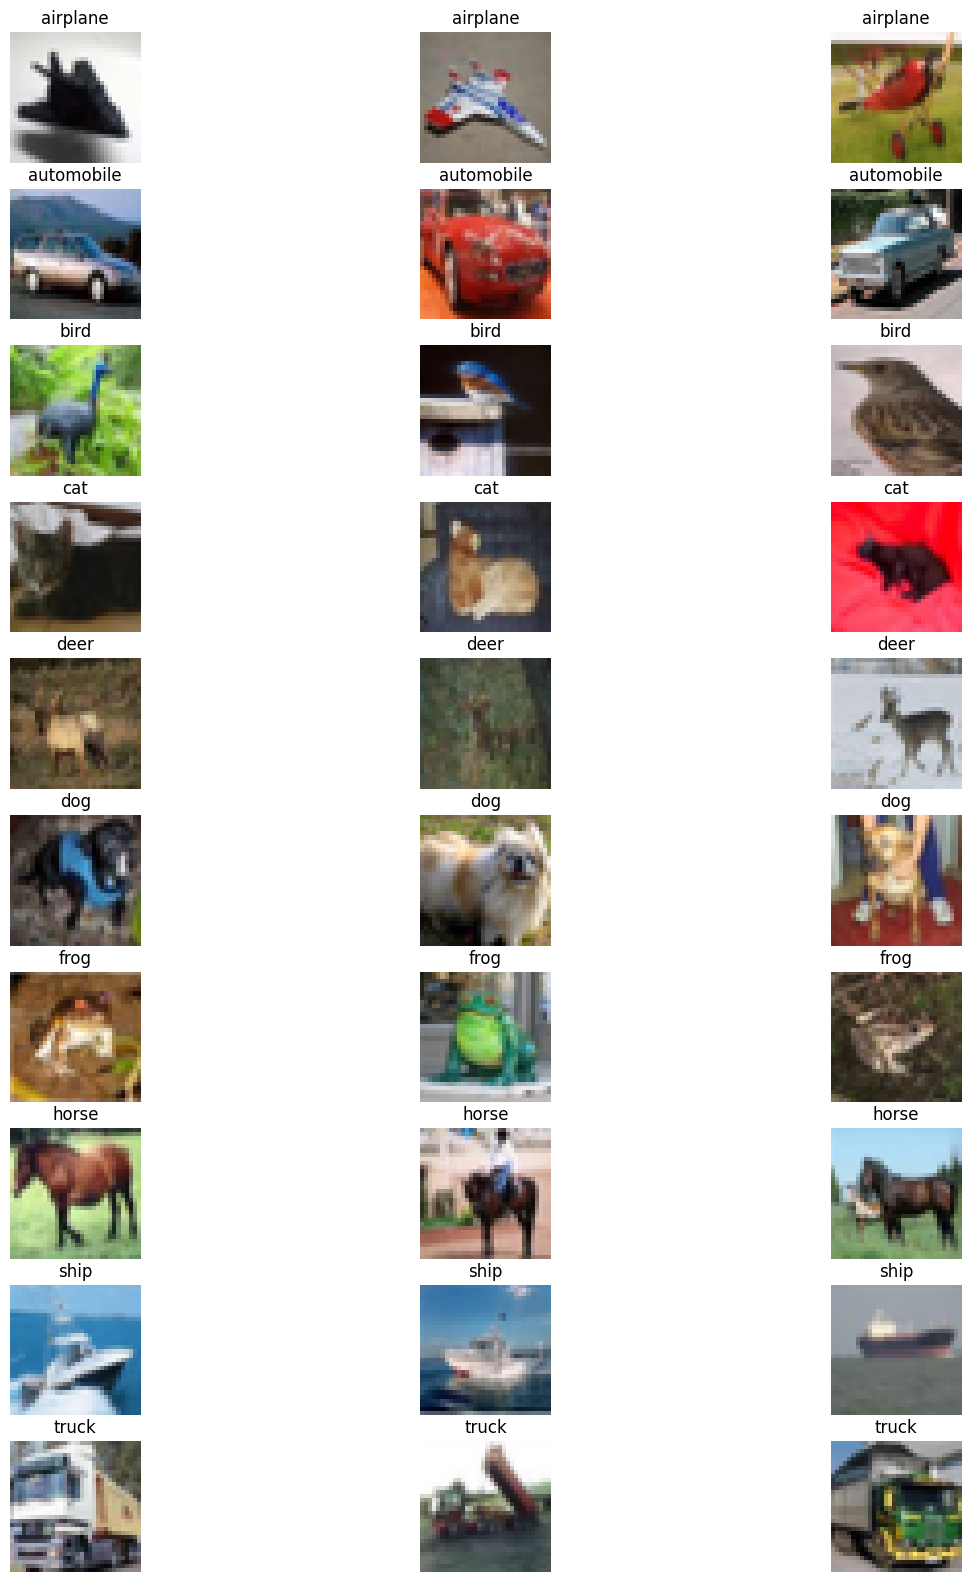

In [10]:
# [Q1]

def visualize_samples(X, Y, num_samples=30):

    # Implement code here

    fig, axes = plt.subplots(10, 3, figsize=(15, 20))

    for i in range(10): #number of the class
      for j in range(3): #jth image of the class


        image = X[np.where(Y==i)[0][j]]*255
        label_index = Y[np.where(Y==i)[0][j]]
        label_name = image_labels[label_index]  # Get label name

        # Display the images on the current subplot

        axes[i][j].imshow(image.astype("uint8"))
        axes[i][j].set_title(label_name)
        axes[i][j].axis('off')

    plt.show()

# Visualizing 30 samples
visualize_samples(X_train_p, Y_train_p, num_samples=30)


## Classification Task

### Model

In [11]:
# [C1]
class ResBlock(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlock, self).__init__()



        # implement code here
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsampling = downsampling
        self.relu1 = layers.LeakyReLU()
        self.relu2 = layers.LeakyReLU()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal', padding="same")
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal', strides = (2 if downsampling else 1), padding="same")


        if downsampling or in_channels != out_channels:
            self.skip = layers.Conv2D(out_channels, kernel_size=1, kernel_initializer = 'he_normal', strides=(2 if downsampling else 1), padding="same", use_bias=False)
        else:
            self.skip = lambda x: x


        # =======================


    def call(self, x):

        # implement code here
        residual = self.skip(x)

        x = self.relu1(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.conv2(x)

        x = layers.add([x, residual])

        return x
        # =======================


In [12]:
# [C2]
class WRN(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRN, self).__init__()
        self.num_classes = num_classes
        # implement code here
        self.conv1 = layers.Conv2D(16, kernel_size=3, kernel_initializer = 'he_normal', padding="same")
        self.block1 = ResBlock(16, 64, downsampling = False)
        self.block2 = ResBlock(64, 64, downsampling = False)
        self.block3 = ResBlock(64, 128, downsampling = True)
        self.block4 = ResBlock(128, 128, downsampling = False)
        self.block5 = ResBlock(128, 256, downsampling = True)
        self.block6 = ResBlock(256, 256, downsampling = False)
        self.relu = layers.LeakyReLU()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)

        # =======================

    def call(self, x):
      x = self.conv1(x)
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)
      x = self.block5(x)
      x = self.block6(x)
      x = self.relu(x)
      x = self.avgpool(x)
      x = self.dense(x)

      return x
        # =======================

### Part 1 Training

In [13]:
# [C3]
def part1_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sigma : float = 0.03) -> dict:

    # implement code here
    # preprocessing


    # one-hot encoding
    one_hot_encoded = tf.one_hot(label, model.num_classes)

    # add noise
    data_augmentation = tf.random.normal(shape=tf.shape(data), mean = 0.0, stddev=sigma)
    data = data + data_augmentation


    # =======================
    # train model
    with tf.GradientTape() as g:

        # implement code here
        # calculate loss here
        logits = model(data)
        loss = tf.keras.losses.categorical_crossentropy(one_hot_encoded, logits, from_logits = True)
        loss = tf.reduce_mean(loss)
        # =======================

    # implement code here
    # obtain the gradients and apply them (using optimizer)
    gradients = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))

    # =======================

    # implement code here
    # return loss (or other values if needed)
    return {
        "loss": loss
    }


    # =======================


In [14]:
def train_loop_1(model, optimizer, train_step, epochs : int = 20, save_interval : int = 5):
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')


### Evaluation

In [15]:
# [C4]
def evaluate_accuracy(model, dataset):
    correct = 0
    total = 0
    # Wrap the dataset with tqdm to create a progress bar
    with tqdm(dataset, unit="batch") as tepoch:
        tepoch.set_description(f"Evaluating")
        for batch_x, batch_y in tepoch:
            batch_size = tf.shape(batch_x)[0]

            # implement code here
            # Compute logits
            logits = model(batch_x)

            # =======================

            # implement code here
            # Cast batch_y to int64 to match preds data type
            casted = tf.cast(batch_y, dtype=tf.int64)

            # =======================

            # implement code here
            # Calculate predictions
            preds = tf.argmax(logits, axis=1)


            # =======================

            # implement code here
            # Update the progress bar description
            correct_predictions = tf.reduce_sum(tf.cast(preds == casted, tf.int64))
            correct += correct_predictions.numpy()
            total += batch_size.numpy()
            accuracy = correct/total
            # =======================
    return accuracy

### Execute training

In [16]:
# Instantiate the model
model = WRN(num_classes=n_class)

# Define the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

In [17]:
train_loop_1(model, optimizer, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.22batch/s]


Test Accuracy: 39.04%
Epoch 1, Average Loss: 2.3145


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 45.35%
Epoch 2, Average Loss: 1.5898


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.58batch/s]


Test Accuracy: 50.79%
Epoch 3, Average Loss: 1.4448


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 53.22%
Epoch 4, Average Loss: 1.3416


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.75batch/s]


Test Accuracy: 55.67%
Epoch 5, Average Loss: 1.2577


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.66batch/s]


Test Accuracy: 58.27%
Epoch 6, Average Loss: 1.1815


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.04batch/s]


Test Accuracy: 62.29%
Epoch 7, Average Loss: 1.1039


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.49batch/s]


Test Accuracy: 61.03%
Epoch 8, Average Loss: 1.0343


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.25batch/s]


Test Accuracy: 62.15%
Epoch 9, Average Loss: 0.9693


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 66.51%
Epoch 10, Average Loss: 0.9144


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.22batch/s]


Test Accuracy: 67.04%
Epoch 11, Average Loss: 0.8616


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.04batch/s]


Test Accuracy: 65.41%
Epoch 12, Average Loss: 0.8169


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.25batch/s]


Test Accuracy: 70.73%
Epoch 13, Average Loss: 0.7616


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.15batch/s]


Test Accuracy: 71.72%
Epoch 14, Average Loss: 0.7171


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.69batch/s]


Test Accuracy: 72.78%
Epoch 15, Average Loss: 0.6764


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.31batch/s]


Test Accuracy: 71.68%
Epoch 16, Average Loss: 0.6384


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.47batch/s]


Test Accuracy: 72.36%
Epoch 17, Average Loss: 0.5885


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.11batch/s]


Test Accuracy: 73.71%
Epoch 18, Average Loss: 0.5472


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.58batch/s]


Test Accuracy: 72.51%
Epoch 19, Average Loss: 0.5054


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 23.36batch/s]


Test Accuracy: 74.52%
Epoch 20, Average Loss: 0.4666


In [18]:
# Saving model
model.save(os.path.join(save_dir, 'my_model.keras'))

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.30batch/s]


Test Accuracy: 0.7452


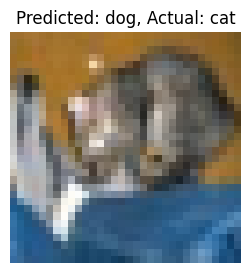

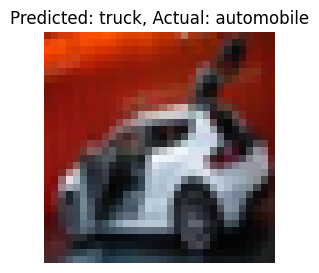

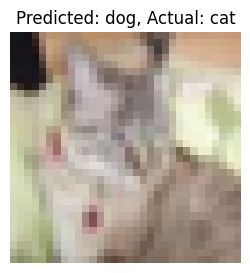

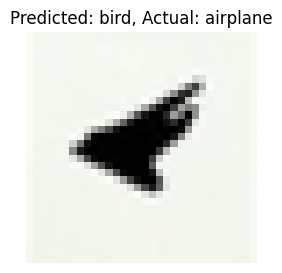

In [19]:
# # [Q5] Report the accuracy of the test dataset and show at least 4 misclassified samples
test_accuracy = evaluate_accuracy(model, test_dataset)
print(f"Test Accuracy: {test_accuracy}")

# Reporting misclassified samples:

test_predictions = []
test_labels = []

# Iterate through the test_dataset to get predictions
for images, labels in test_dataset:
    predictions = tf.argmax(model(images), axis=1)
    test_predictions.extend(predictions.numpy())
    test_labels.extend(labels.numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

# Find misclassified samples
misclassified_indices = np.where(test_predictions != test_labels)[0]
misclassified_images = X_test_p[misclassified_indices]
misclassified_labels = test_labels[misclassified_indices]
misclassified_predictions = test_predictions[misclassified_indices]

# Report 4 misclassified samples
for i in range(4):
    plt.figure(figsize=(3, 3))
    plt.imshow(misclassified_images[i])
    plt.title(f"Predicted: {image_labels[misclassified_predictions[i]]}, Actual: {image_labels[misclassified_labels[i]]}")
    plt.axis('off')
    plt.show()


### Regularization

In [20]:
# [C5] Implement your regularization method here

class ResBlockRE(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlockRE, self).__init__()


        # implement code here
        # implement the methods by modifying this class
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsampling = downsampling
        self.relu1 = layers.LeakyReLU()
        self.relu2 = layers.LeakyReLU()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal',padding="same")
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides = (2 if downsampling else 1), kernel_initializer = 'he_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()


        if downsampling or in_channels != out_channels:
            self.skip = layers.Conv2D(out_channels, kernel_size=1, strides=(2 if downsampling else 1), kernel_initializer = 'he_normal', padding="same", use_bias=False)
        else:
            self.skip = lambda x: x


        # =======================


    def call(self, x):
        # implement code here
        residual = self.skip(x)

        x = self.relu1(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.norm2(x)

        # print("Shape of x:", tf.shape(x))
        # print("Shape of residual:", tf.shape(residual))
        x = layers.add([x, residual])

        return x


        # =======================

class WRNRE(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRNRE, self).__init__()

        # implement code here
        self.num_classes = num_classes
        # implement code here
        self.conv1 = layers.Conv2D(16, kernel_size=3, kernel_initializer = 'he_normal', padding="same")
        self.block1 = ResBlockRE(16, 64, downsampling = False)
        self.block2 = ResBlockRE(64, 64, downsampling = False)
        self.block3 = ResBlockRE(64, 128, downsampling = True)
        self.block4 = ResBlockRE(128, 128, downsampling = False)
        self.block5 = ResBlockRE(128, 256, downsampling = True)
        self.block6 = ResBlockRE(256, 256, downsampling = False)
        self.relu = layers.LeakyReLU()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)


        # =======================

    def call(self, x):
        # implement code here

        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.dense(x)
        return x


        # =======================


In [21]:
# Instantiate the model
model_re = WRNRE(num_classes=n_class)

# Define the optimizer
optimizer_re = optimizers.Adam(learning_rate=learning_rate)


In [22]:
train_loop_1(model_re, optimizer_re, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.13batch/s]


Test Accuracy: 39.37%
Epoch 1, Average Loss: 2.2382


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.79batch/s]


Test Accuracy: 45.07%
Epoch 2, Average Loss: 1.5893


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.16batch/s]


Test Accuracy: 50.84%
Epoch 3, Average Loss: 1.4481


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.08batch/s]


Test Accuracy: 53.94%
Epoch 4, Average Loss: 1.3415


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.17batch/s]


Test Accuracy: 57.04%
Epoch 5, Average Loss: 1.2508


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.97batch/s]


Test Accuracy: 61.26%
Epoch 6, Average Loss: 1.1652


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.45batch/s]


Test Accuracy: 61.50%
Epoch 7, Average Loss: 1.0833


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.92batch/s]


Test Accuracy: 64.46%
Epoch 8, Average Loss: 1.0198


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 64.24%
Epoch 9, Average Loss: 0.9522


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.75batch/s]


Test Accuracy: 66.29%
Epoch 10, Average Loss: 0.8963


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 66.68%
Epoch 11, Average Loss: 0.8451


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.11batch/s]


Test Accuracy: 70.22%
Epoch 12, Average Loss: 0.7845


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 70.79%
Epoch 13, Average Loss: 0.7407


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 71.08%
Epoch 14, Average Loss: 0.6997


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.89batch/s]


Test Accuracy: 73.57%
Epoch 15, Average Loss: 0.6470


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.84batch/s]


Test Accuracy: 70.44%
Epoch 16, Average Loss: 0.6123


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 73.35%
Epoch 17, Average Loss: 0.5733


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.07batch/s]


Test Accuracy: 73.56%
Epoch 18, Average Loss: 0.5194


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.85batch/s]


Test Accuracy: 72.75%
Epoch 19, Average Loss: 0.4960


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]

Test Accuracy: 73.79%
Epoch 20, Average Loss: 0.4486


In [23]:
# Saving model
model_re.save(os.path.join(save_dir_re, 'my_model_re.keras'))


In [24]:
# [Q6] Report the accuracy of the test dataset after implementing regularization methods
test_accuracy_re = evaluate_accuracy(model_re, test_dataset)
print(f"Regularized Model Test Accuracy: {test_accuracy_re}")

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.29batch/s]

Regularized Model Test Accuracy: 0.7379


## Part 2: Generation Task

### Energy Function

In [25]:
# [C6]
def energy(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None):
  # implement code here
  logits = model(data)
  #when labels are given, we calculate energies for all labels and aggregate them
  if label is not None:
    labels_onehot = tf.one_hot(label, depth=logits.shape[-1])
    return - tf.reduce_sum(logits * labels_onehot, axis=-1)
  else:
    return -tf.reduce_logsumexp(logits, axis=1)

  # =======================


In [26]:
def visualize_energy(model: tf.keras.Model, sample_index: int = 20):
    # Sample an image from the test dataset
    # implement code here
    real_image = X_test_p[sample_index]
    real_label = Y_test_p[sample_index]

    #noise and grey images for comparison
    noise_image = np.random.uniform(0, 1, size=real_image.shape)
    grey_image = np.full(real_image.shape, 0.5)

    # =======================
    images = [real_image, noise_image, grey_image]
    exy = []
    ex = []
    names = ['Real', 'Noise', 'Grey']
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(names):
        exy.append(energy(model, tf.expand_dims(images[i], 0), real_label).numpy()[0])
        ex.append(energy(model, tf.expand_dims(images[i], 0)).numpy()[0])
        axes[i].imshow(images[i])
        axes[i].set_title(f"{ax} E(x,y): {exy[i]:.2f}, E(x) {ex[i]:.2f}")
        axes[i].axis('off')
    plt.show()

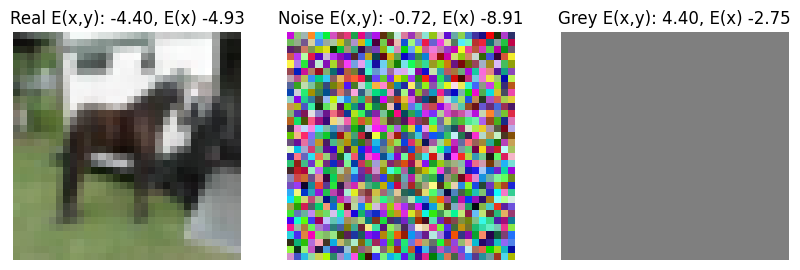

In [27]:
# [Q7]
visualize_energy(model, 20)

### Sampling x

In [28]:
# [C7]
def sampling_step(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None, step_size : float = 1, noise_amp : float = 0.01):
    # This forces the gradient tape to only track gradients for the input data:
    with tf.GradientTape(watch_accessed_variables = False) as g:
        g.watch(data)
        # calculate energy here (aggregate with sum)
        # implement code here
        energy_value = energy(model, data, label)
        energy_sum = tf.reduce_sum(energy_value)
        # =======================


    # implement code here

    # calculate the gradient
    gradient = g.gradient(energy_sum, data)

    # =======================

    # implement code here

    # update data with gradient + gaussian noise
    data = tf.cast(data, tf.float32) - tf.cast(step_size, tf.float32) * tf.cast(gradient, tf.float32) + tf.random.normal(shape=tf.shape(data), mean = 0.0, stddev=noise_amp, dtype=tf.float32)
    # =======================


    # ensure that the sample is in the valid pixel space
    data = tf.clip_by_value(data, 0, 1)

    return data

### Replay Buffer

In [29]:
# [C8]
class SampleBuffer:
    """ A buffer storing some past trained (negative) samples. """
    def __init__(self, sample_shape, n_class : int, max_samples : int = 10000, dtype : np.dtype = np.float32):
        self.max_samples = max_samples
        self.sample_shape = sample_shape
        self.n_class = n_class
        self.dtype = dtype
        self.buffer = []

    def add_to_buffer(self, samples, ids):
        """ Add samples to replay buffer (self.buffer). If there are too many samples in the buffer, remove the oldest ones (first in, first out). """
        # implement code here
        # self.buffer.extend(zip(samples, ids))
        for i in range(len(samples)):
          self.buffer.append((samples[i], ids[i]))

        if (len(self.buffer) > self.max_samples):
            self.buffer = self.buffer[len(self.buffer)-self.max_samples:]

        # =======================

    def sample_from_buffer(self, n_samples : int, p_new : float = 0.05):
        """ Sample batch of n_sample samples, with each sample being either new (with probability p_new) or from buffer."""
        if len(self.buffer) == 0:
            # Initial case
            n_new = n_samples
        else:
            n_new = np.random.binomial(n_samples, p_new)

        if n_new > 0:
            # Sample uniform random data
            # implement code here
            noise = np.random.uniform(0, 1, size=(n_new, *self.sample_shape))
            noise_class = np.random.randint(0, self.n_class, size=n_new)
            # =======================
        else:
            noise, noise_class = [], []

        if n_new < n_samples:
            # Sample from existing data
            # implement code here
            # replay_samples = np.random.choice(self.buffer, size=n_samples-n_new, replace=False)
            # replay = np.array([sample[0] for sample in replay_samples])
            # replay_class = np.array([sample[1] for sample in replay_samples])
            indices = np.random.choice(len(self.buffer), size=n_samples - n_new, replace=False)
            replay = np.array([self.buffer[i][0] for i in indices])
            replay_class = np.array([self.buffer[i][1] for i in indices])



            # =======================
        else:
            replay, replay_class = [], []

        sample = tf.stack(list(noise) + list(replay), axis = 0)
        sample_class = tf.stack(list(noise_class) + list(replay_class), axis = 0)

        return sample, sample_class

In [30]:
def visualize_buffer_samples(buffer : SampleBuffer, num_samples : int = 16, p_new : float = 0.05):
    # Retrieve samples and their corresponding labels from the buffer
    samples, labels = buffer.sample_from_buffer(num_samples, p_new)
    # Visualize the samples
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(samples[i].numpy())  # Convert to uint8 for proper image display
        plt.xlabel(image_labels[labels[i].numpy()])
    plt.show()

sample_shape = X_train_p[0].shape
buffer = SampleBuffer(sample_shape, n_class)
# Add some initial data to the buffer
buffer.add_to_buffer(X_train_p[:100], Y_train_p[:100])  # Add first 100 samples as an example

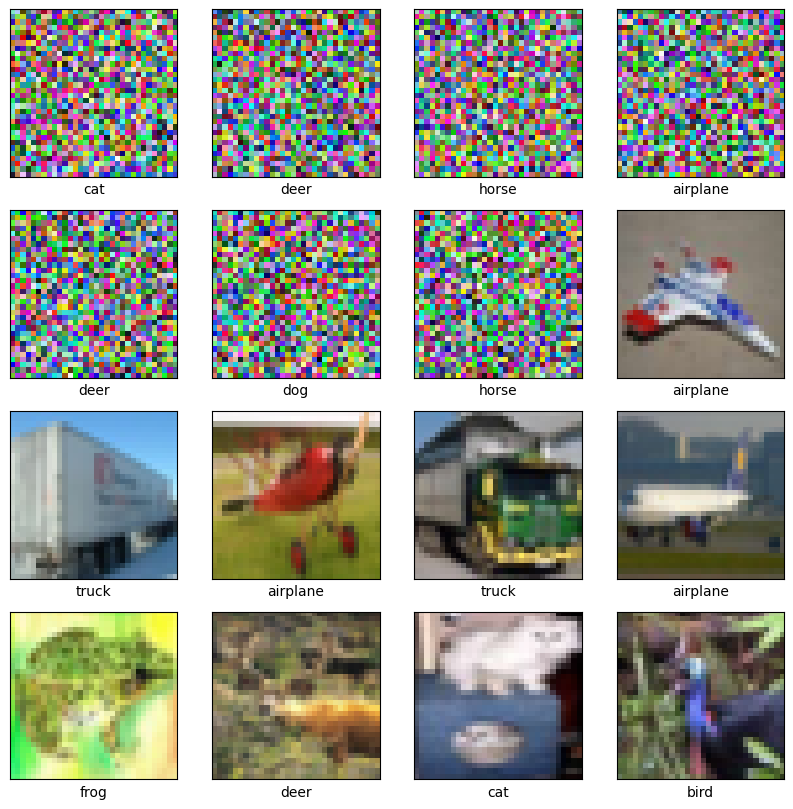

In [31]:
#[Q8]
visualize_buffer_samples(buffer, num_samples=16, p_new=0.5)

### JEM Training

In [32]:
#[C9]
def part2_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sb : SampleBuffer, sigma : float = 0.03) -> dict:
    batch_size = len(data)
    # preprocessing
    x, y = (data + tf.random.normal(data.shape) * sigma), tf.one_hot(label, model.num_classes)

    # implement code here

    # sample images and labels (x', y') from SampleBuffer
    x_p, y_p = sb.sample_from_buffer(batch_size, p_new = 0.05)

    #
    # run sampling step on x' 20 times, then add the final result back to the buffer
    for i in range(20):
        x_p = sampling_step(model, x_p, y_p)
    sb.add_to_buffer(x_p, y_p)
    # =======================


    # train model
    with tf.GradientTape() as g:
        # implement code here

        # calculate loss here, by:
        # 1. obtainig model output for x and x'
        logits = model(x, training = True)
        logits_p = model(x_p, training = True)
        # 2. calculate cross-entropy and energy values
        centry = tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        energy_value = energy(model, x)
        energy_value_p = energy(model, x_p)
        # 3. aggregate and calculate the final loss using the mentioned values
        loss = centry + energy_value - energy_value_p
        loss = tf.reduce_mean(loss)
        # =======================
    # obtain the gradients and apply them (using optimizer)
    centry = tf.reduce_mean(centry)
    grad = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    # return loss (or other values if needed)
    return {
        "loss": loss.numpy(),
        "class_loss": centry.numpy()
    }

In [33]:
def train_loop_2(model, optimizer, train_step, epochs : int = 5, save_interval : int = 1, buffer : SampleBuffer | None = None) -> SampleBuffer:
    if buffer is None:
        buffer = SampleBuffer(X_train[0].shape, n_class)
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y, buffer)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')

    return buffer

### Execute training

In [34]:
# Instantiate the model
model_2 = WRN(num_classes=n_class)

# Define the optimizer
optimizer_2 = optimizers.Adam(learning_rate=learning_rate)

If the training diverges, please restart the training

In [35]:
buf = train_loop_2(model_2, optimizer_2, part2_train_step, 2)

Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 25.33%
Epoch 1, Average Loss: 3.0852


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.22batch/s]


Test Accuracy: 28.19%
Epoch 2, Average Loss: 2.1522
